In [42]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv1D, Input, Dense, Dropout, GlobalMaxPooling1D # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.metrics import BinaryAccuracy # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

FOLDER_FILTER = '../24h-ecg-normalized-filter/'
FOLDER_QC_MODEL_TUNNING = '/qc_model_tuning/'
DATASET_QC = "../dataset-qc-model/"
DATASET_QC_TEST = "../dataset-qc-test/"
MODEL = "../model/"
FOLDER_QC_MODEL = 'qc-model/'
LABEL_FILE = "label.txt"

Num GPUs Available:  0


# Build QC Model for check quality segment using for Stroke model

# 131 low-quality segments; 666 high-quality segments; 1 label file .txt

In [55]:
def load_data(dataset_path, label_file):
    X = []
    y = []
    with open(os.path.join(dataset_path, label_file), 'r') as file:
        for line in file:
            file_name, label = line.split()
            label = float(label)
            with open(os.path.join(dataset_path, file_name), 'r') as signal_file:
                signal = np.loadtxt(signal_file)
            X.append(signal)
            y.append(int(label))
    return np.array(X), np.array(y)

X, y = load_data(DATASET_QC, LABEL_FILE)
print(X.shape, y.shape) 

(797, 6000, 5) (797,)


In [56]:
checkpoint_path = os.path.join(MODEL + FOLDER_QC_MODEL_TUNNING, "qc_checkpoint.keras")
model_path = os.path.join(MODEL + FOLDER_QC_MODEL_TUNNING, "qc_model.keras")

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    
if os.path.exists(model_path):
    os.remove(model_path)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

input_dim = (6000, 5)
epochs = 100
batch_size = 32

def qc_model(hp):
    model = Sequential()
    model.add(Input(shape=input_dim))
    model.add(Conv1D(filters=hp.Int('num_filters', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Int('kernel_size', min_value=3, max_value=30, step=3),
                     strides=hp.Int('stride', min_value=1, max_value=10, step=1),
                     activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.05)))
    # model.add(Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'))
    # model.add(Dropout(hp.Float('dropout_rate_dense', min_value=0.2, max_value=0.7, step=0.05)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    return model

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

tuner = kt.Hyperband(
    qc_model,
    objective='binary_accuracy',
    max_epochs=100,
    factor=3,
    directory=MODEL,
    project_name='qc_model_tuning'
)

tuner.search(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val), batch_size = batch_size, callbacks = callbacks)

qc_tuning_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
score = qc_tuning_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Save the best model
qc_tuning_model.save(model_path)


Trial 254 Complete [00h 01m 01s]
binary_accuracy: 0.8428290486335754

Best binary_accuracy So Far: 0.8840864300727844
Total elapsed time: 00h 54m 49s
Test loss: 0.36392879486083984
Test accuracy: 0.862500011920929


In [57]:
tuning_mapping = tuner.get_best_hyperparameters(num_trials=1)[0]

kernel_size = tuning_mapping.get('kernel_size')
stride = tuning_mapping.get('stride')
num_filters = tuning_mapping.get('num_filters')
dropout_rate = tuning_mapping.get('dropout_rate')
learning_rate = tuning_mapping.get('learning_rate')

print(f"num_filters {num_filters}")
print(f"kernel_size {kernel_size}")
print(f"stride {stride}")
print(f"dropout_rate {dropout_rate}")
print(f"learning_rate {learning_rate}")

num_filters 112
kernel_size 30
stride 1
dropout_rate 0.5
learning_rate 0.0007367975947793897


# Tunning hyperparameter manually 

In [58]:
checkpoint_path = os.path.join(MODEL + FOLDER_QC_MODEL, "qc_checkpoint.keras")
model_path = os.path.join(MODEL + FOLDER_QC_MODEL, "qc_model.keras")

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    
if os.path.exists(model_path):
    os.remove(model_path)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

input_dim = (6000, 5)
# kernel_size = 20
# stride = 10
# num_filters = 32
# dropout_rate = 0.5
# learning_rate = 0.001

def qc_model():
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, strides=stride, activation='relu', input_shape=input_dim))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    
    return model

# Model checkpoints
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

qc_manual_model = qc_model()

# Train the model
history = qc_manual_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

# Save the trained model
qc_manual_model.save(model_path)

Epoch 1/100


/Users/macad/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - binary_accuracy: 0.7786 - loss: 0.5535
Epoch 1: val_loss improved from inf to 0.34990, saving model to ../model/qc-model/qc_checkpoint.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - binary_accuracy: 0.7806 - loss: 0.5503 - val_binary_accuracy: 0.8828 - val_loss: 0.3499 - learning_rate: 7.3680e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - binary_accuracy: 0.8089 - loss: 0.4845
Epoch 2: val_loss did not improve from 0.34990
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - binary_accuracy: 0.8096 - loss: 0.4831 - val_binary_accuracy: 0.8828 - val_loss: 0.3613 - learning_rate: 7.3680e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - binary_accuracy: 0.8246 - loss: 0.4524
Epoch 3: val_loss improved from 0.34990 to 0.34507, saving model to ../model/qc-model/qc_checkpoint.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - binary_accuracy: 0.8244 - loss: 0.4525 - val_binary_accuracy: 0.8828 - val_loss: 0.3451 - learning_rate: 7.3680e-0

# Tracking validation and training loss

tuning
Test loss: 36.39%
Test accuracy: 86.25%
manual
Test loss: 36.84%
Test accuracy: 85.62%


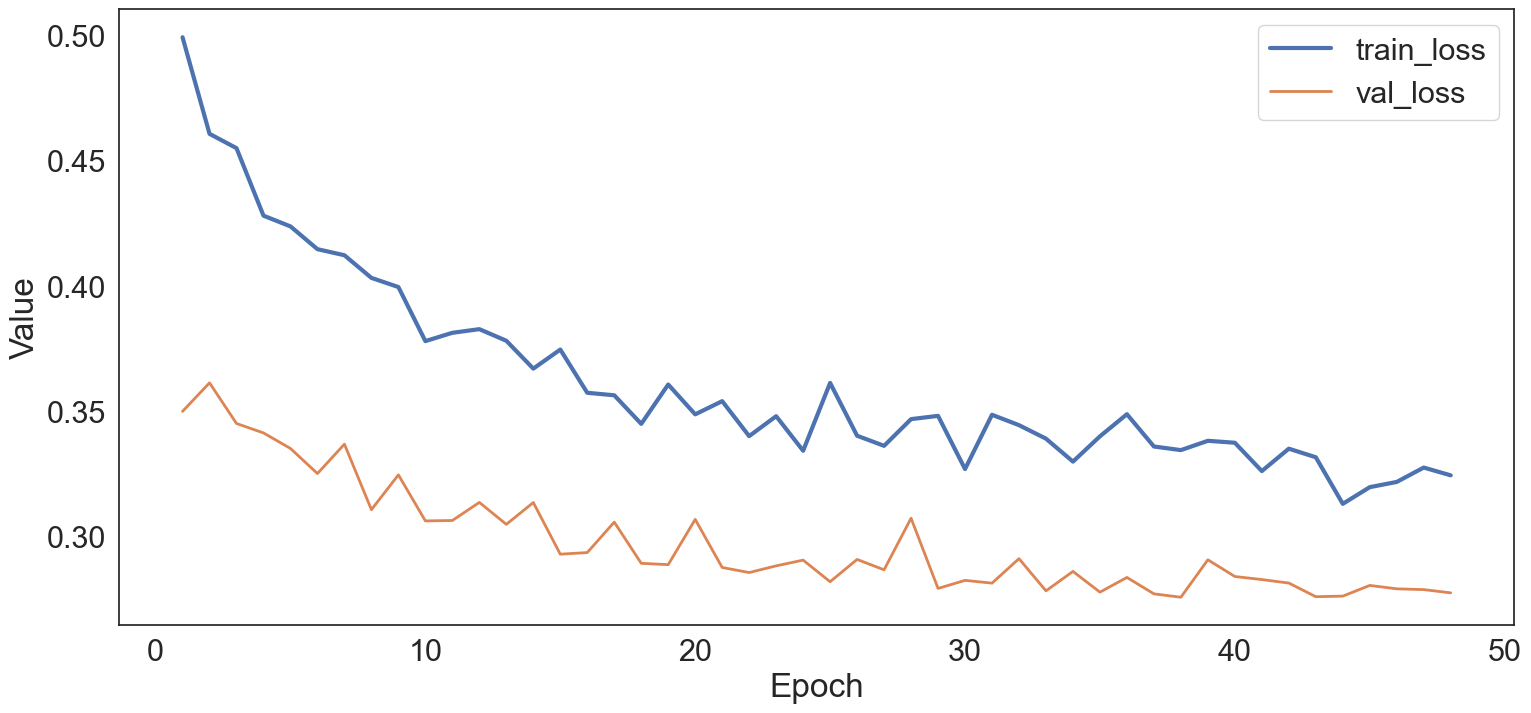

In [59]:
score = qc_tuning_model.evaluate(X_test, y_test, verbose=0)
print("tuning")
print(f"Test loss: {score[0] * 100:.2f}%")
print(f"Test accuracy: {score[1] * 100:.2f}%")

test_loss, test_accuracy = qc_manual_model.evaluate(X_test, y_test, verbose=0)
print("manual")
print(f'Test loss: {test_loss * 100:.2f}%')
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 8))
sns.set(font_scale=2)
sns.set_style("white")

plt.plot(range(1, len(train_loss) + 1), train_loss, label='train_loss', linewidth=3.0)
plt.plot(range(1, len(val_loss) + 1), val_loss, label='val_loss', linewidth=2.0)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [63]:
val_loss

[0.3498997390270233,
 0.3613056540489197,
 0.34506964683532715,
 0.34130334854125977,
 0.33509963750839233,
 0.3250858187675476,
 0.3368171155452728,
 0.3106508255004883,
 0.3245631456375122,
 0.3061782419681549,
 0.30633044242858887,
 0.31356334686279297,
 0.30479544401168823,
 0.31350433826446533,
 0.2928811311721802,
 0.2935309112071991,
 0.30569252371788025,
 0.2892357409000397,
 0.2887040078639984,
 0.3067724108695984,
 0.28757885098457336,
 0.2855469286441803,
 0.2882261574268341,
 0.2905125319957733,
 0.2818857431411743,
 0.29079028964042664,
 0.28664064407348633,
 0.3072505593299866,
 0.2792074978351593,
 0.28242480754852295,
 0.2813246250152588,
 0.2910962402820587,
 0.27823886275291443,
 0.2860042452812195,
 0.27771979570388794,
 0.2835977375507355,
 0.2770451605319977,
 0.27568697929382324,
 0.29065102338790894,
 0.28396791219711304,
 0.2827487289905548,
 0.281360387802124,
 0.2759060263633728,
 0.2761390805244446,
 0.28040599822998047,
 0.27905574440956116,
 0.2787409722805

In [60]:
qc_manual_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 5971, 112)      │        16,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 112)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,077 (199.52 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,052 (133.02 KB)

# Load model predict quality of dataset and manual validation

In [61]:
def grid_plot(folder, page, pageSize = 24, num_cols = 4):
    dataset = get_main_names_of_files(folder)
    file_names = paging(dataset, page, pageSize)

    num_plots = len(file_names)
    num_cols = num_cols
    num_rows = int(np.ceil(num_plots / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10))

    for i, file_name in enumerate(file_names):
        print(f'{file_name}_p_signal.txt')
        title = file_name
        file_name = os.path.join(folder, f'{file_name}_p_signal.txt')
        
        row = i // num_cols
        col = i % num_cols
        data = np.loadtxt(file_name) 
        data = data[:,0]
        axs[row, col].plot(data)
        axs[row, col].set_title(title, size=10)
        
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

def get_main_names_of_files(x):
    file_names = os.listdir(x)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

def paging(data, page, page_size):
  if page <= 0 or page_size <= 0:
    return [] 

  start_index = (page - 1) * page_size
  end_index = start_index + page_size

  if end_index > len(data):
    end_index = len(data)

  return data[start_index:end_index]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
File: s0322-07052204_31_p_signal.txt, Prediction: [[0.07113245]] 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
File: s0322-07052204_54_p_signal.txt, Prediction: [[0.15544648]] 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
File: s0322-07052204_22_p_signal.txt, Prediction: [[0.04013322]] 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
File: s0402-08010704_64_p_signal.txt, Prediction: [[0.9542613]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
File: s0402-08010704_24_p_signal.txt, Prediction: [[0.92503375]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
File: s0402-08010704_98_p_signal.txt, Prediction: [[0.9470917]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
File: s0402-08010704_79_p_signal.txt, Prediction: [[0.9545111]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
File: s0322-07052204_21_p_signal.txt, Prediction: [[0.18959679]] 
s0322-07052204_31_p_signal.txt
s0322-07052204_54_p_signal.txt
s0322-07052204_22_p_signal.txt
s0

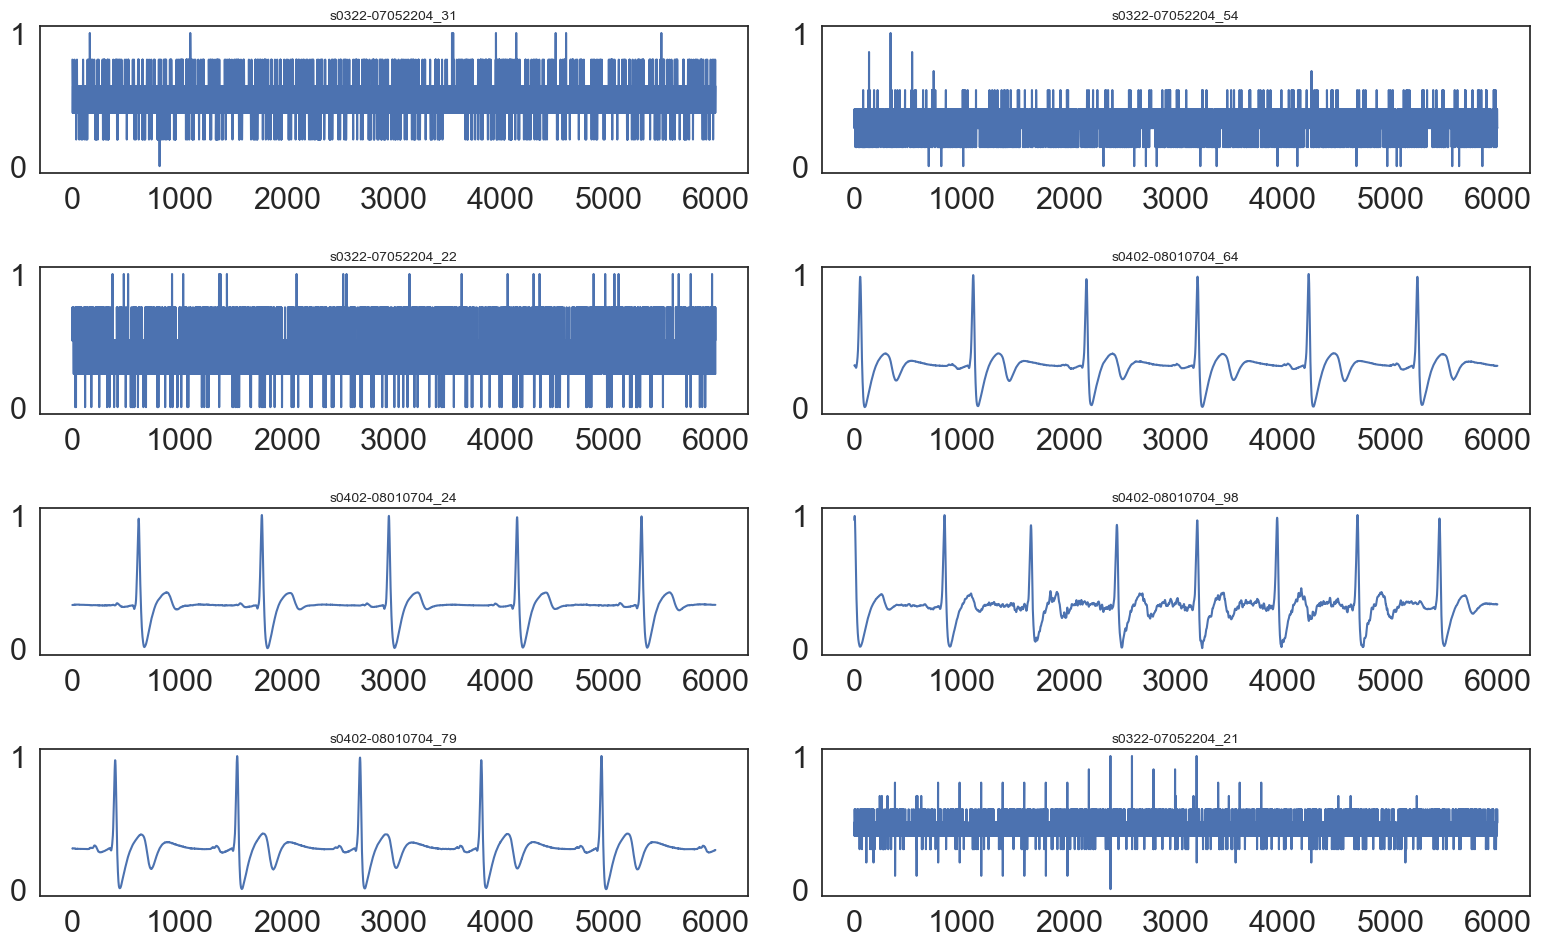

[0.36839526891708374, 0.856249988079071]
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Train MSE: 0.09492741474999097
Test MSE: 0.10962828130929117
____________________
Train MAE: 0.1893703924557871
Test MAE: 0.2102709916420281
____________________
Train MAPE: 485197597971872.44
Test MAPE: 556246717851238.4
____________________
Train RMSE: 0.3081029288241041
Test RMSE: 0.33110161779926595
____________________
Train RMSPE: [1.29411925e+15]
Test RMSPE: [1.37497247e+15]


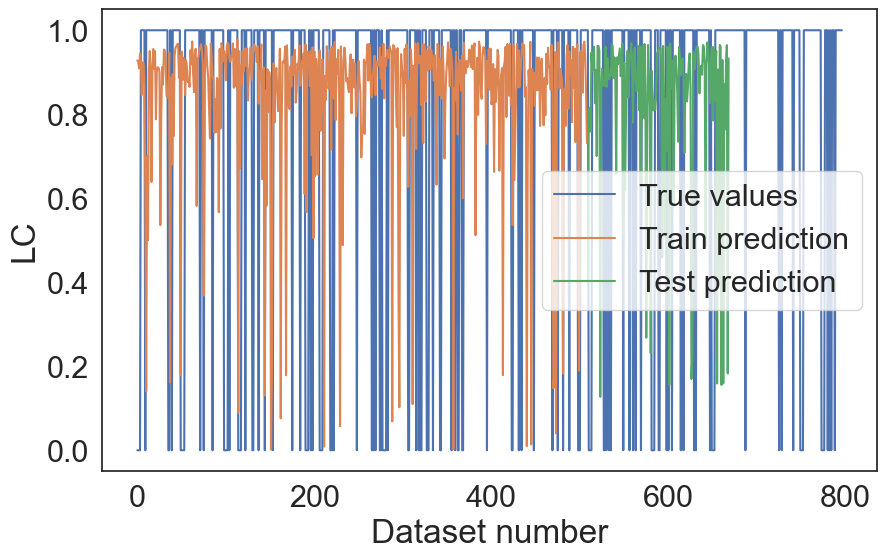

In [62]:
loaded_model = load_model(os.path.join(MODEL, FOLDER_QC_MODEL + "qc_model.keras"))

for file_name in os.listdir(DATASET_QC_TEST):
    if file_name.endswith('signal.txt'):
        file_path = os.path.join(DATASET_QC_TEST, file_name)
        with open(file_path, 'r') as signal_file:
            signal = np.loadtxt(signal_file)
            prediction = loaded_model.predict(np.expand_dims(signal, axis=0))  
            quality_label = "--> QUALITY SEGMENT" if prediction > 0.5 else ""
            print(f"File: {file_name}, Prediction: {prediction} {quality_label}")
    
grid_plot(DATASET_QC_TEST, 1, 8, 2)

score = qc_manual_model.evaluate(X_test, y_test, batch_size=20, verbose=0)
print(score)

train_predict = loaded_model.predict(X_train)
test_predict = loaded_model.predict(X_test)

# Assuming scaler was used for normalization
scaler = MinMaxScaler()
scaler.fit(y.reshape(-1, 1))  # Fit on the original data labels

# Inverse transform predictions and true values
train_predict = scaler.inverse_transform(train_predict)
train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
train_mae = mean_absolute_error(train_true, train_predict)
test_mae = mean_absolute_error(test_true, test_predict)
train_mape = mean_absolute_percentage_error(train_true, train_predict)
test_mape = mean_absolute_percentage_error(test_true, test_predict)
train_mse = mean_squared_error(train_true, train_predict)
test_mse = mean_squared_error(test_true, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Avoid division by zero for RMSPE calculation
epsilon = np.finfo(float).eps
train_true_safe = np.where(train_true == 0, epsilon, train_true)
test_true_safe = np.where(test_true == 0, epsilon, test_true)
train_rmspe = np.sqrt(np.mean(np.square((train_true - train_predict) / train_true_safe), axis=0))
test_rmspe = np.sqrt(np.mean(np.square((test_true - test_predict) / test_true_safe), axis=0))

# Print error metrics
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print("____________________")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print("____________________")
print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")
print("____________________")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print("____________________")
print(f"Train RMSPE: {train_rmspe}")
print(f"Test RMSPE: {test_rmspe}")

# Prepare data for plotting
train_predict_plot = np.empty_like(y, dtype=np.float32).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(y, dtype=np.float32).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict):len(train_predict) + len(test_predict), :] = test_predict

true_values = y.reshape(-1, 1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.xlabel("Dataset number")
plt.ylabel("LC")
plt.plot(true_values, label="True values")
plt.plot(train_predict_plot, label="Train prediction")
plt.plot(test_predict_plot, label="Test prediction")
plt.legend()
plt.show()